In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# read in raw data

df_wFORM = pd.read_parquet('./datasets/Results from Eneli March 2025/inference_metrics_full_train_with_form.pq')
df_noFORM = pd.read_parquet('./datasets/Results from Eneli March 2025/inference_metrics_full_train_without_form.pq')

In [3]:
# extract data based on station ID

FOA_M14_wFORM = df_wFORM.iloc[0:2068]
FOA_M14_noFORM = df_noFORM.iloc[0:2068]
FOA_M31_wFORM = df_wFORM.iloc[2069:4137]
FOA_M31_noFORM = df_noFORM.iloc[2069:4137]
FOA_M7_wFORM = df_wFORM.iloc[4138:4772]
FOA_M7_noFORM = df_noFORM.iloc[4138:4772]
FOA_M54_wFORM = df_wFORM.iloc[4773:6835]
FOA_M54_noFORM = df_noFORM.iloc[4773:6835]
Ammonit_wFORM = df_wFORM.iloc[6836:]
Ammonit_noFORM = df_noFORM.iloc[6836:]


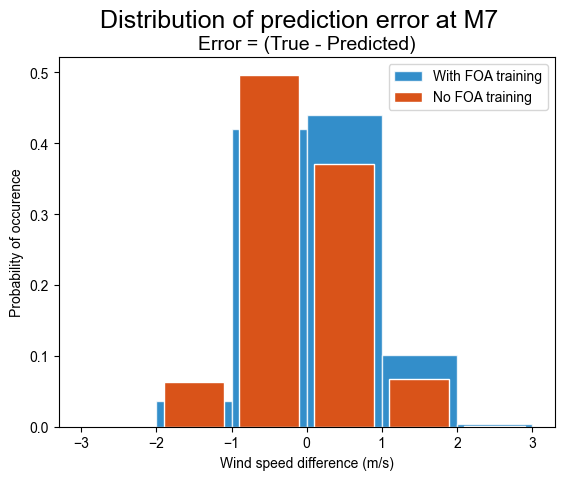

In [44]:
# make histogram of M7 error

# define error
FOA_M7_error_wFORM = FOA_M7_wFORM['wspeed_true'] - FOA_M7_wFORM['wspeed_pred']
FOA_M7_error_noFORM = FOA_M7_noFORM['wspeed_true'] - FOA_M7_noFORM['wspeed_pred']

# set wind speed range bins
bin_edges = [-3, -2, -1, 0, 1, 2, 3]

# compute histogram counts
counts_wFORM, edges_wFORM = np.histogram(FOA_M7_error_wFORM, bins=bin_edges)
counts_noFORM, edges_noFORM = np.histogram(FOA_M7_error_noFORM, bins=bin_edges)
counts_wFORM = counts_wFORM / counts_wFORM.sum() 

plt.hist(FOA_M7_error_noFORM, bins=bin_edges, color=(0, 0.4470, 0.7410), edgecolor='white', density=True, alpha=0.8)
plt.bar(edges_wFORM[:-1]+0.5, counts_wFORM, width=0.8, color=(0.8500, 0.3250, 0.0980), edgecolor='white')
# plt.hist(FOA_M7_error_noFORM, bins=bin_edges, color=(0.8500, 0.3250, 0.0980))

# FOA_M7_error_wFORM.hist(bins=bin_edges, alpha=0.85, color=(0, 0.4470, 0.7410))
# FOA_M7_error_noFORM.hist(bins=bin_edges, alpha=0.5, color=(0.8500, 0.3250, 0.0980))

# Add a title and labels
plt.rcParams["font.family"] = "Arial"
plt.suptitle('Distribution of prediction error at M7', fontsize=18)
plt.title('Error = (True - Predicted)', fontsize=14)
plt.xlabel('Wind speed difference (m/s)')
plt.ylabel('Probability of occurence')
plt.legend(('With FOA training', 'No FOA training'))

# Show the plot
plt.show()